In [1]:
%load_ext autoreload
%autoreload 2

In [94]:
import mitsuba as mi
mi.set_variant('cuda_ad_rgb')

import synthnf.inspection as ins
import synthnf.inspection.swing_supressing_inspection as ssi

from tqdm.auto import tqdm
import logging
mi.set_log_level(mi.LogLevel.Error)

import synthnf.simulation as simu
import synthnf.inspection as inspection

import numpy as np
import matplotlib.pyplot as plt

import pathlib
import tempfile

import synthnf.io as io
import synthnf.config.defaults as defaults
import synthnf.config.assets as assets
import synthnf.scene as scene

In [219]:
from synthnf.inspection import FAInspection


class ControlledInspection(FAInspection):
    def __init__(self, params):
        super(self.__class__, self).__init__(params)
        
    def render_frame(
            self, 
            cam_z, 
            light_intensity,
            cam_fov = 28,
            face_num=1, 
            has_alpha = False,
            cam_x=0,
    ):
        scene_dict = scene.inspection_dict(
            cam_z=cam_z, 
            cam_x=cam_x,
            face_num=face_num,
            cam_ligth_intensity=light_intensity,
            cam_fov = cam_fov
        )

        scene_dict["tips"] = self.model_tips.copy()
        scene_dict["butts"] = self.model_butts.copy()
        scene_dict["model"] = self.model_fa.copy()

        keys = [f"model_grid_{int(i)}" for i in range(len(self.model_grids))]
        for key, g in zip(keys, self.model_grids):
            scene_dict[key] = g.copy()

        model_keys = ["tips", "butts", "model", *keys]
        if has_alpha:
            return scene.render_scene(scene_dict, spp=128*8, alpha=True, denoise=False)
        else:
            return scene.render_scene(scene_dict, spp=128, alpha=False, denoise=True)

In [439]:
class Renderer:
    def render_tips(
        light_intensity = 50,
        cloudiness = .7,
        y = 3800,
        z_displacement = 0,
        cam_fov = 28,
        has_alpha = False,
        seed = 123,
        cam_x = 0,
        z_displacement_base = 0,
    ):
        z_displacement_base -= 27
        params = simu.RandomParameters(
            seed = seed,
            cloudiness=cloudiness,
            max_z_displacement_mm=z_displacement,
            n_textures = 11,
            z_displacement_base = z_displacement_base,
        )
        fains = ControlledInspection(
            params,
        )

        # define origin rod a grid positions
        rod_pos = np.zeros([13,2])
        rod_pos[:11,0] = fains.rod_centers[:11,0][::-1]
        rod_pos[:11,1] = fains.z_displacement[:11][::-1]
        rod_pos[11] = [63.75,-30.41438306921569]
        rod_pos[12] = [-63.75,-30.41438306921569]

        # transform all label positions
        rod_pos2 = np.zeros([rod_pos.shape[0],3])
        rod_pos2[:,0] = (-rod_pos[:,0] + cam_x) * (300 / 63.75) + 360 - 20
        rod_pos2[:,1] = (-rod_pos[:,0] + cam_x) * (300 / 63.75) + 360 + 20
        rod_pos2[:,2] = (-rod_pos[:,1] + y - 3800) * (276 / 57.83110821) + 287

        rod_pos2[:,:2] = ((rod_pos2[:,:2]) - 360) * (np.tan(28 * (np.pi / 360)) / np.tan(cam_fov * (np.pi / 360))) + 360
        rod_pos2[:,2] = ((rod_pos2[:,2]) - 288) * (np.tan(28 * (np.pi / 360)) / np.tan(cam_fov * (np.pi / 360))) + 288

        rod_pos2 = rod_pos2.astype(int)
        
        return fains.render_frame(
            y,
            light_intensity = light_intensity,
            has_alpha=has_alpha,
            cam_fov = cam_fov,
            cam_x = cam_x
        )[12:-12,15:-15], rod_pos2

In [440]:
import scipy.ndimage
import cv2
import skimage.exposure
import numpy as np
from numpy.random import default_rng

class Transformer:
    def distorsion(img, label, alpha = 1.0):
        k_1 = alpha * 0.2
        k_2 = alpha * 0.05

        h,w = img.shape[:2]
        x,y = np.meshgrid(np.float32(np.arange(w)),np.float32(np.arange(h))) # meshgrid for interpolation mapping

        # center and scale the grid for radius calculation (distance from center of image)
        x_c = w/2 
        y_c = h/2 
        x = x - x_c
        y = y - y_c
        x = x/x_c
        y = y/y_c

        radius = np.sqrt(x**2)# + y**2) # distance from the center of image

        m_r = 1 + k_1*radius + k_2*radius**2 # radial distortion model

        # apply the model 
        x= x * m_r 
        #y = y * m_r

        # reset all the shifting
        x= x*x_c + x_c
        y = y*y_c + y_c

        dist_label = np.zeros(label.shape)
        for i in range(len(dist_label)):
            dist_label[i,0] = np.argmin(np.abs(x[0] - label[i,0]))
            dist_label[i,1] = np.argmin(np.abs(x[0] - label[i,1]))
            dist_label[i,2] = label[i,2]
        dist_label = dist_label.astype(int)

        distorted = np.zeros(img.shape)
        for c in range(3):
            dist = scipy.ndimage.map_coordinates(img[:,:,c], [y.ravel(),x.ravel()])
            dist.resize(img.shape[:2])
            distorted[:,:,c] = dist
            
        return distorted, dist_label
    
    def perspective(img, label, alpha = 1.0):
        shift = min(720, int(100 * alpha))
        if alpha >= 0:
            pts1 = np.float32([[0, 0], [576, shift],
                            [0, 720], [576, 720-shift]])
        else:
            pts1 = np.float32([[0, -shift], [576, 0],
                            [0, 720+shift], [576, 720]])
        pts2 = np.float32([[0, 0], [576, 0],
                       [0, 720], [576, 720]])
        
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(img, matrix, (720, 576))

        dist_label = np.zeros(label.shape)
        for i in range(len(dist_label)):
            p1 = matrix @ np.asarray([label[i,0], label[i,2], 1])
            p1 = p1 / p1[2]
            dist_label[i,0] = p1[0]

            p2 = matrix @ np.asarray([label[i,1], label[i,2], 1])
            p2 = p2 / p2[2]
            dist_label[i,1] = p2[0]
            
            dist_label[i,2] = (p1[1] + p2[1]) // 2
        dist_label = dist_label.astype(int)

        return result, dist_label
    
    def rotate(img, label, alpha = 1.0):
        result = scipy.ndimage.rotate(img, alpha, reshape=False)

        angle = np.deg2rad(-alpha)
        R = np.array([[np.cos(angle), -np.sin(angle)],
                  [np.sin(angle),  np.cos(angle)]])
        o = np.asarray(img.shape[:2])[::-1] // 2
    
        rot_label = np.zeros(label.shape)
        for i in range(len(rot_label)):
            p1 = np.asarray([label[i,0], label[i,2]], dtype=np.float32)
            p1 = np.squeeze((R @ (p1.T-o.T) + o.T).T)
            rot_label[i,0] = p1[0]

            p2 = np.asarray([label[i,1], label[i,2]])
            p2 = np.squeeze((R @ (p2.T-o.T) + o.T).T)
            rot_label[i,1] = p2[0]
            
            rot_label[i,2] = (p1[1] + p2[1]) // 2
        rot_label = rot_label.astype(int)

        return result, rot_label
    
    def stains(img, label, size = 15, alpha = 1.0):
        rng = default_rng()
        h,w = img.shape[:2]

        # create random noise image
        noise = rng.integers(0, 255, (h,w), np.uint8, True)

        # blur the noise image to control the size
        blur = cv2.GaussianBlur(noise, (0,0), sigmaX=size, sigmaY=size, borderType = cv2.BORDER_DEFAULT)

        # stretch the blurred image to full dynamic range
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

        result = np.zeros(img.shape)
        for i in range(3):
            result[:,:,i] = alpha * (stretch / 255) + img[:,:,i]

        result[np.where(result < 0)] = 0
        result[np.where(result > 1)] = 1

        return result, label
    
    def contrast(img, label, alpha = 0.5):
        result = (img - np.median(img)) * alpha + np.median(img)
        result[np.where(result < 0)] = 0
        result[np.where(result > 1)] = 1
        return result, label
    
    def gauss_noise(img, label, alpha = 0.01):
        gauss = np.random.normal(0, alpha**0.5, img.shape[:2])
        gauss_frame = np.zeros(img.shape)
        for i in range(3):
            gauss_frame[:,:,i] = img[:,:,i] + gauss
        gauss_frame[np.where(gauss_frame < 0)] = 0
        gauss_frame[np.where(gauss_frame > 1)] = 1
        return gauss_frame, label
    
    def blur(img, label, alpha = 0):
        return scipy.ndimage.gaussian_filter(img,alpha), label

In [457]:
import cv2

class Generator:
    def generate(
        light_intensity = 50,
        cloudiness = .7,
        y = 3800,
        z_displacement = 0,
        cam_fov = 28,
        seed = 123,
        cam_x = 0,
        z_displacement_base = 0,
        distorsion = 0.0,
        perspection = 0.0,
        rotation = 0.0,
        staining = 0.0,
        contrast = 1.0,
        gauss_noise = 0.0,
        blur = 0,
        plot = False,
        path = None,
    ):
        frame, label = Renderer.render_tips(
            light_intensity=light_intensity,
            cloudiness=cloudiness,
            y = y,
            z_displacement=z_displacement,
            cam_fov=cam_fov,
            seed = seed,
            cam_x=cam_x,
            z_displacement_base=z_displacement_base)
        
        frame, label = Transformer.distorsion(frame, label, alpha = distorsion)
        frame, label = Transformer.perspective(frame, label, alpha = perspection)
        frame, label = Transformer.rotate(frame, label, alpha = rotation)
        frame, label = Transformer.stains(frame, label, alpha = staining)
        frame, label = Transformer.contrast(frame, label, alpha = contrast)
        frame, label = Transformer.gauss_noise(frame, label, alpha = gauss_noise)
        frame, label = Transformer.blur(frame, label, alpha = blur)

        # extract grid position
        print(label[11:])
        p1 = [(label[11,0] + label[11,1])/2, label[11,2]]
        p2 = [(label[12,0] + label[12,1])/2, label[12,2]]
        grid_pos = [0, -1,719, -1]
        grid_pos[1] = p1[1] + (p1[1] - p2[1]) * (p1[0] / (p2[0] - p1[0]))
        grid_pos[3] = p2[1] - (p1[1] - p2[1]) * ((719 - p2[0]) / (p2[0] - p1[0]))
        grid_pos = np.asarray(grid_pos).astype(int)

        #extract rod positions
        rod_pos = np.zeros([11,4])
        rod_pos[:,0::2] = label[:11,:2]
        rod_pos[:,1] = label[:11,2]
        rod_pos[:,3] = label[:11,2]
        rod_pos = rod_pos.astype(int)

        #plot result
        if plot:
            plt.figure(figsize=(10,8))
            plt.imshow(frame)
            for i in range(len(rod_pos)):
                p = rod_pos[i]
                plt.plot([p[0], p[2]], [p[1], p[3]])
            p = grid_pos
            plt.plot([p[0], p[2]], [p[1], p[3]])
            plt.show()

        #save result
        if path is not None:
            frame2 = np.copy(frame)
            for i in range(len(rod_pos)):
                p = rod_pos[i]
                frame2[p[1],p[0]:p[2],2] = 1
            p = grid_pos
            frame2[p[1],p[0]:p[2],2] = 1
            cv2.imwrite(path, frame2*255)
        
        return frame, rod_pos, grid_pos

[[157 175 315]
 [507 533 299]]


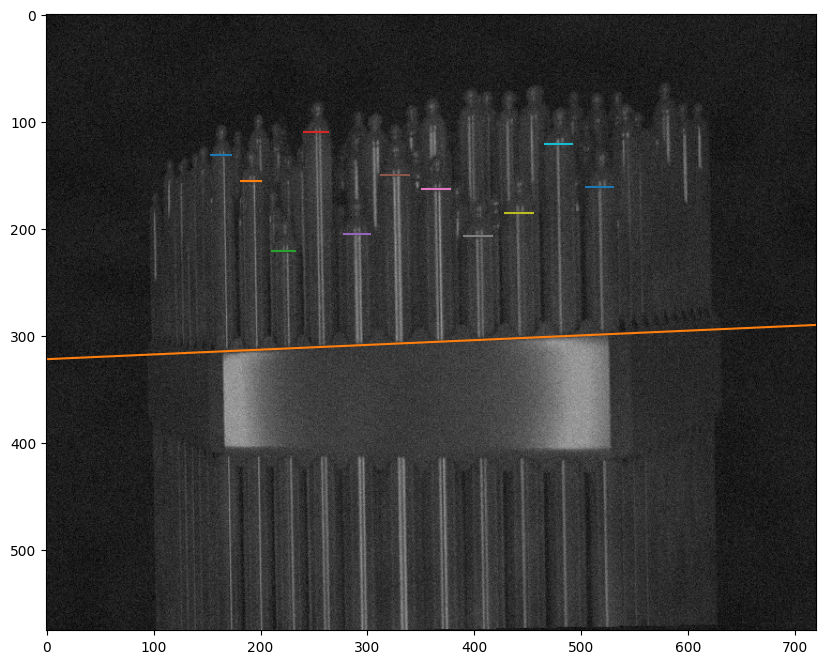

[  0 322 719 290]


In [459]:
frame, rod_pos, grid_pos = Generator.generate(
    z_displacement_base=20, 
    z_displacement=40,
    cam_x=5, 
    distorsion=1.0, 
    perspection = 1.0, 
    rotation = 1.0,
    staining = 0.1, 
    contrast = 0.5,
    light_intensity = 100,
    cloudiness = 0.4,
    gauss_noise = 0.001,
    blur = 0,
    y = 3780,
    cam_fov = 45,
    plot = True,
    path = "example2.png"
)
print(grid_pos)

# Výška tyčí

(576, 720, 3)

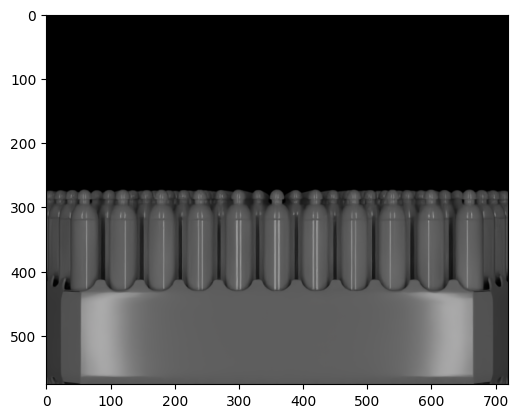

In [108]:
base_frame = render_tips(z_displacement_base=20)[12:-12,15:-15]
plt.imshow(base_frame)
base_frame.shape

# X posun

(576, 720, 3)

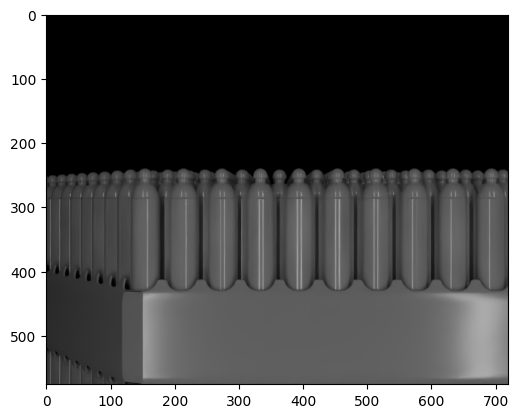

In [73]:
shift_frame = render_tips(cam_x = 20)[12:-12,15:-15]
plt.imshow(shift_frame)
shift_frame.shape

# Distorze + Perspektiva + Rotace + Fleky

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.005874086637049913..0.6750337481498718].


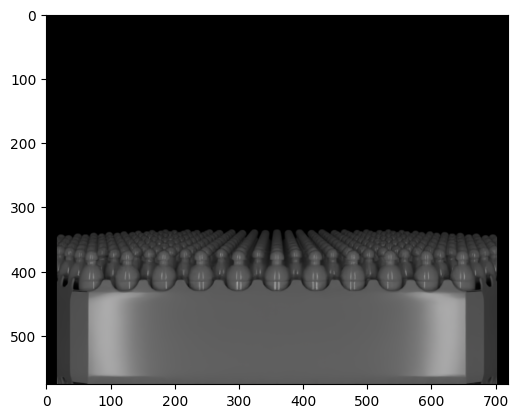

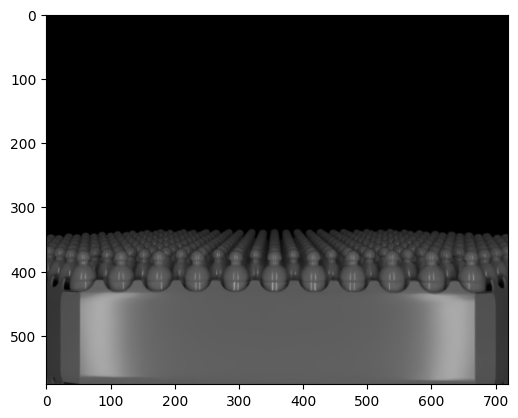

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.009985786..0.6965421].


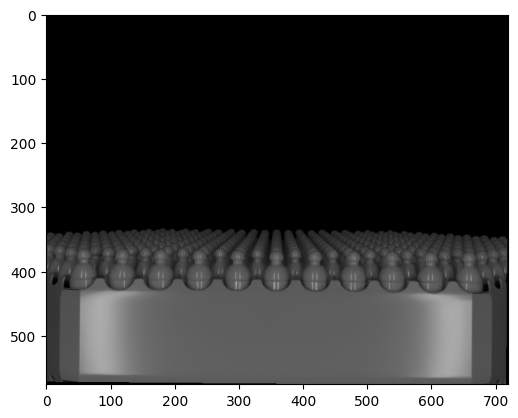

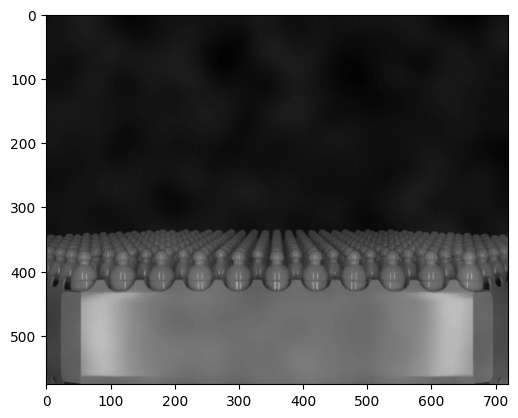

(576, 720, 3)

In [142]:
import scipy.ndimage
import cv2
import skimage.exposure
import numpy as np
from numpy.random import default_rng

class Transformer:
    def distorsion(img, alpha = 1.0):
        k_1 = alpha * 0.2
        k_2 = alpha * 0.05

        h,w = img.shape[:2]
        x,y = np.meshgrid(np.float32(np.arange(w)),np.float32(np.arange(h))) # meshgrid for interpolation mapping

        # center and scale the grid for radius calculation (distance from center of image)
        x_c = w/2 
        y_c = h/2 
        x = x - x_c
        y = y - y_c
        x = x/x_c
        y = y/y_c

        radius = np.sqrt(x**2)# + y**2) # distance from the center of image

        m_r = 1 + k_1*radius + k_2*radius**2 # radial distortion model

        # apply the model 
        x= x * m_r 
        #y = y * m_r

        # reset all the shifting
        x= x*x_c + x_c
        y = y*y_c + y_c

        distorted = np.zeros(img.shape)
        for c in range(3):
            dist = scipy.ndimage.map_coordinates(img[:,:,c], [y.ravel(),x.ravel()])
            dist.resize(img.shape[:2])
            distorted[:,:,c] = dist
            
        return distorted
    
    def perspective(img, alpha = 1.0):
        shift = min(720, int(100 * alpha))
        if alpha >= 0:
            pts1 = np.float32([[0, 0], [576, shift],
                            [0, 720], [576, 720-shift]])
        else:
            pts1 = np.float32([[0, -shift], [576, 0],
                            [0, 720+shift], [576, 720]])
        pts2 = np.float32([[0, 0], [576, 0],
                       [0, 720], [576, 720]])
        
        # Apply Perspective Transform Algorithm
        matrix = cv2.getPerspectiveTransform(pts1, pts2)
        result = cv2.warpPerspective(img, matrix, (720, 576))

        return result
    
    def rotate(img, alpha = 1.0):
        return scipy.ndimage.rotate(img, alpha, reshape=False)
    
    def stains(img, size = 15, alpha = 1.0):
        rng = default_rng()
        h,w = img.shape[:2]

        # create random noise image
        noise = rng.integers(0, 255, (h,w), np.uint8, True)

        # blur the noise image to control the size
        blur = cv2.GaussianBlur(noise, (0,0), sigmaX=size, sigmaY=size, borderType = cv2.BORDER_DEFAULT)

        # stretch the blurred image to full dynamic range
        stretch = skimage.exposure.rescale_intensity(blur, in_range='image', out_range=(0,255)).astype(np.uint8)

        result = np.zeros(img.shape)
        for i in range(3):
            result[:,:,i] = alpha * (stretch / 255) + img[:,:,i]

        result[np.where(result < 0)] = 0
        result[np.where(result > 1)] = 1

        return result

    
dist_frame = Transformer.distorsion(base_frame, alpha = 0.2)
plt.imshow(dist_frame)
plt.show()
dist_frame.shape

pers_frame = Transformer.perspective(base_frame, alpha = 0.1)
plt.imshow(pers_frame)
plt.show()
pers_frame.shape

rot_frame = Transformer.rotate(base_frame, alpha = -0.5)
plt.imshow(rot_frame)
plt.show()
rot_frame.shape

stain_frame = Transformer.stains(base_frame, alpha = 0.14, size = 20)
plt.imshow(stain_frame)
plt.show()
stain_frame.shape

# Kontrast

(576, 720, 3)

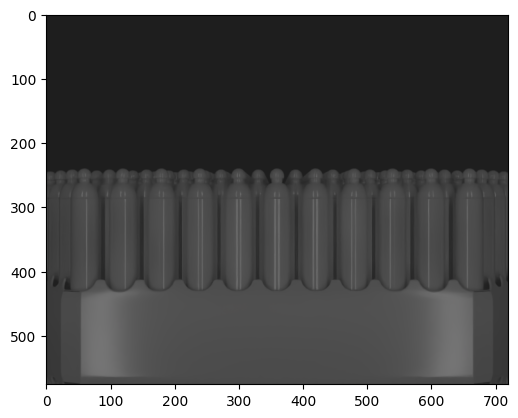

In [66]:
import cv2

contrast = 0.5
base_frame = render_tips()[12:-12,15:-15]

contrast_frame = (base_frame - np.median(base_frame)) * contrast + np.median(base_frame)
contrast_frame[np.where(contrast_frame < 0)] = 0
contrast_frame[np.where(contrast_frame > 1)] = 1

plt.imshow(contrast_frame)
contrast_frame.shape

# Jas

Lze naimpolementovat na úrovni obrazu nebo na renderigu. V rámci renderování je přidáme na intenzitě světla

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.3096081].


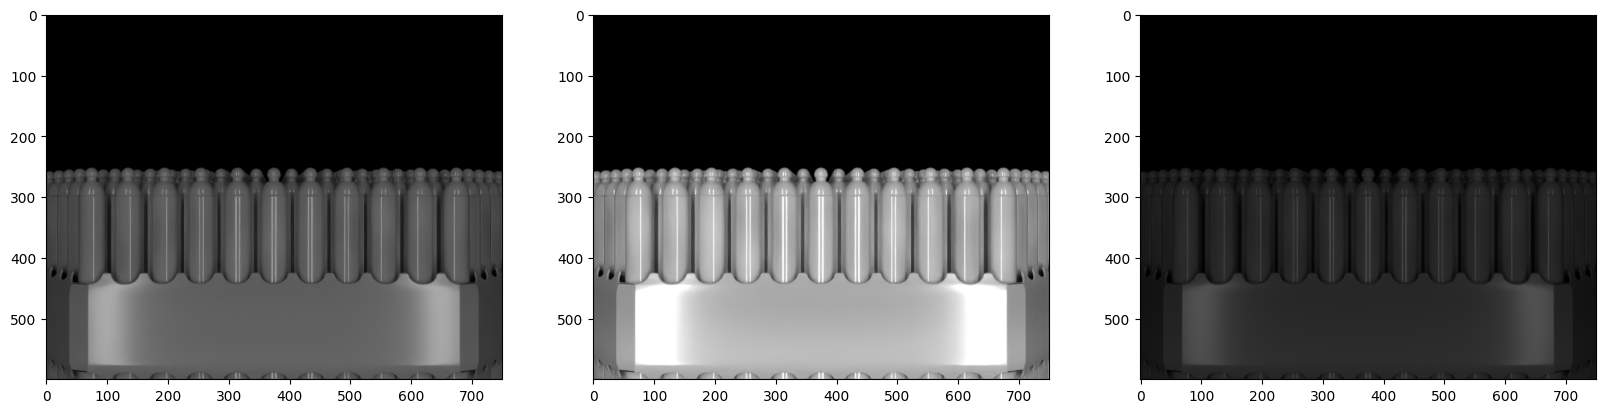

In [43]:
burnt = render_tips(light_intensity=200)
dim = render_tips(light_intensity=10)

fig,(axr,axc, axl) = plt.subplots(1,3,figsize=(20,10))
axr.imshow(base_frame)
axc.imshow(burnt)
axl.imshow(dim)

# Mat/Odrazivost

Matnost povrchu je úměrná oxidaci. Matné je to úměrně k hodnotě `cloudiness`

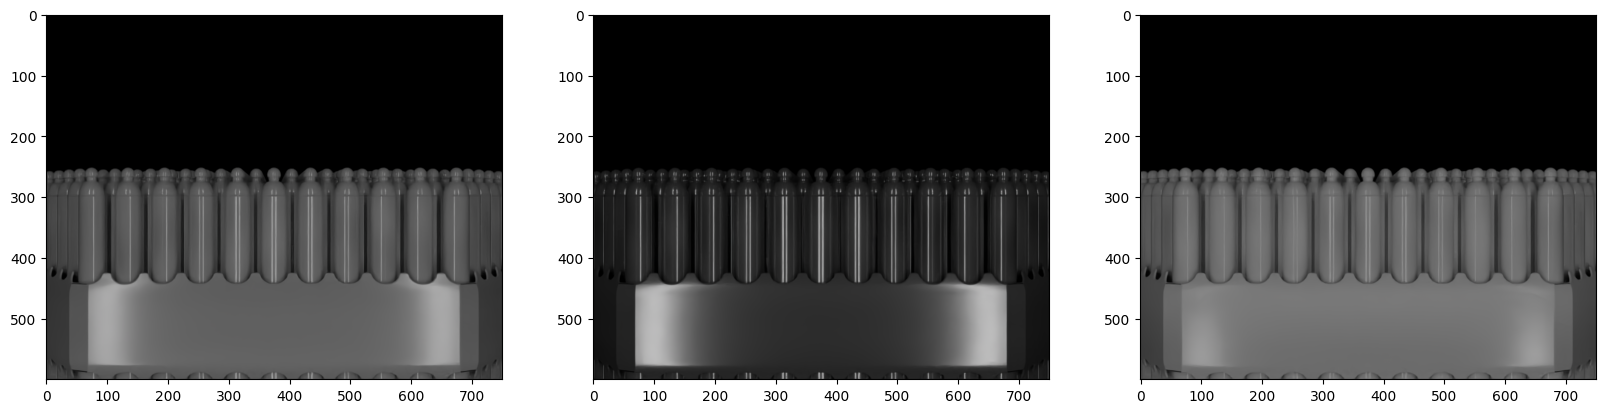

In [44]:
refl = render_tips(cloudiness=.4)
matte = render_tips(cloudiness=.8)

fig,(axr,axc, axl) = plt.subplots(1,3,figsize=(20,10))
axr.imshow(base_frame)
axc.imshow(refl)
axl.imshow(matte)

# Obraz

- proutky se vystrkují pomocí `z displacemnet` parametru. jedná se o maximální displacement. Ten reálný je generovaný náhodně (náhodu lze kontrolovat pomocí parametru `seed`)
- zaměření kamery lze měnit pomocí `fov`
- posun v ose y  - `y` (defaultní hodnota je 3800, protože to je výška ve které se špičky nachází  a 0 je patice)

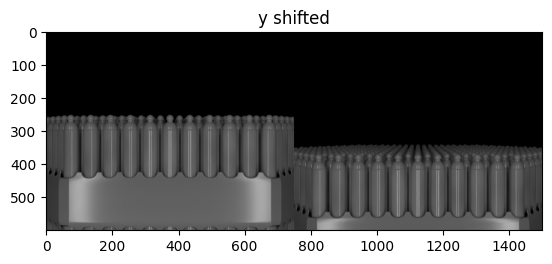

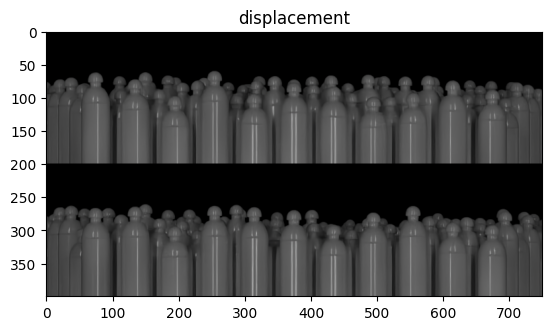

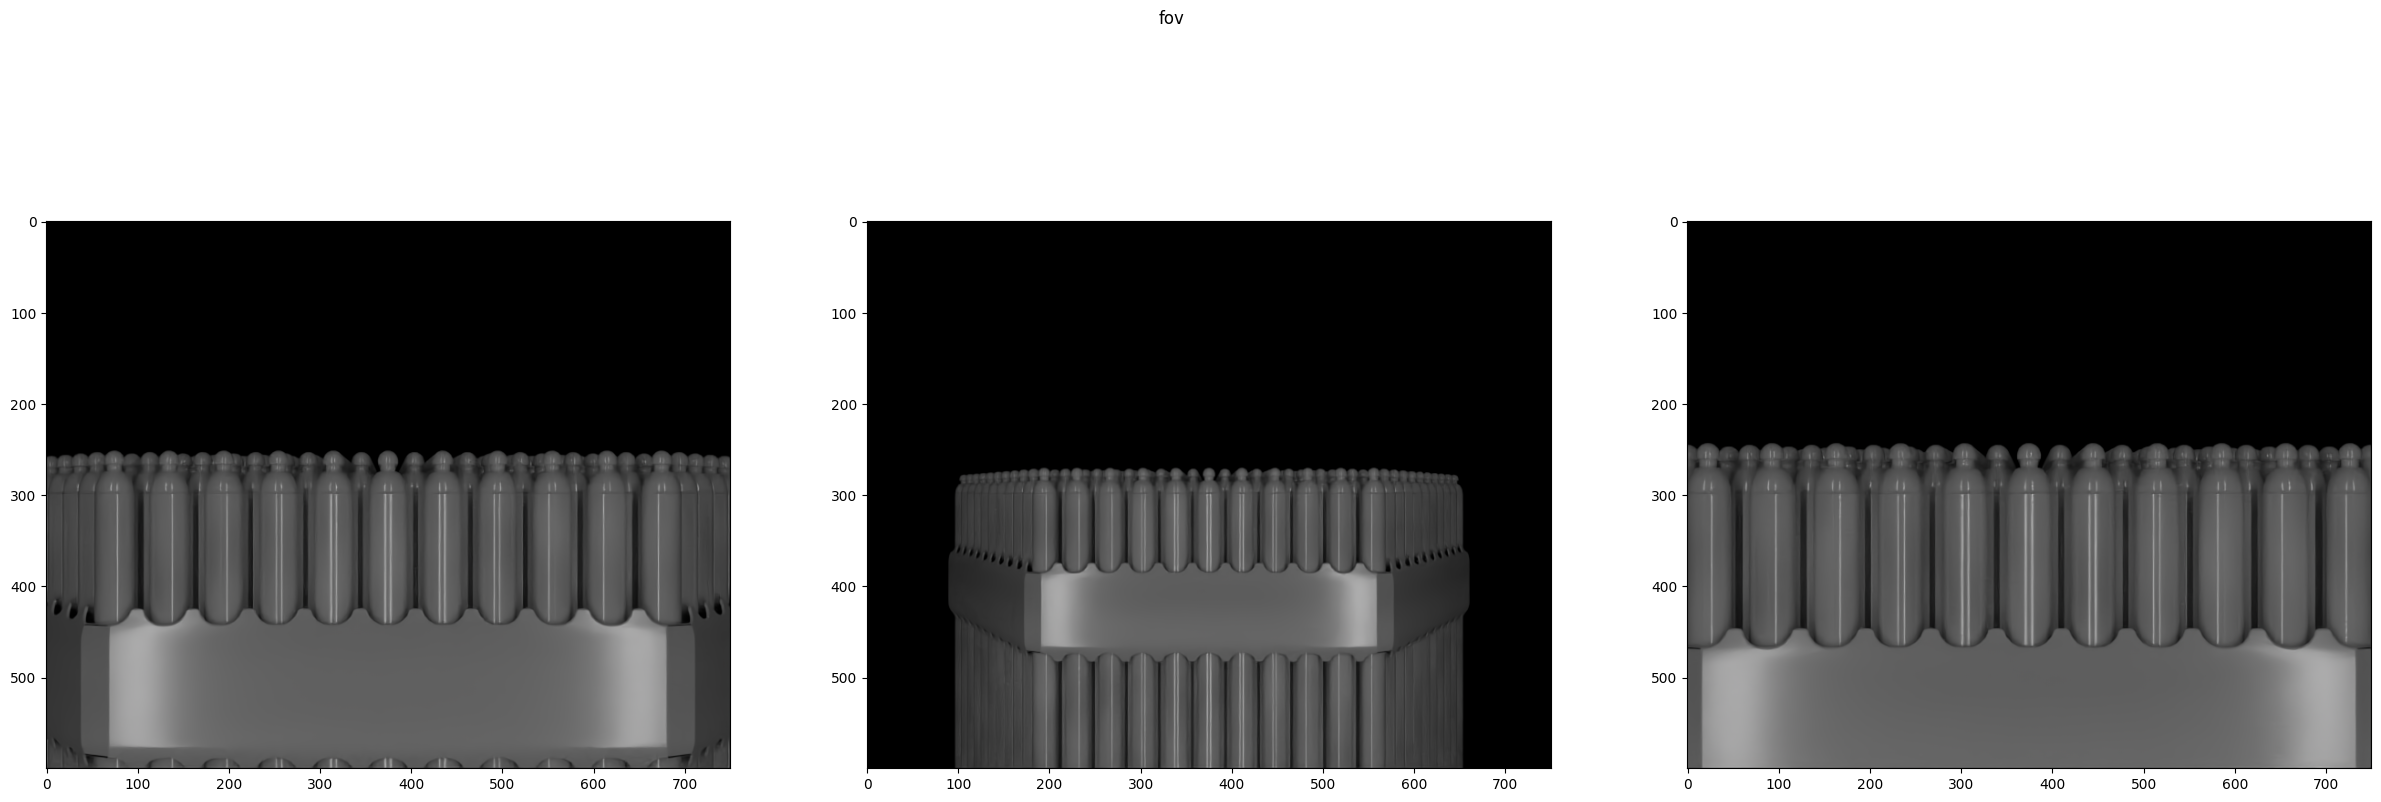

In [45]:
shifted_y = render_tips(y = 3825)
plt.title("y shifted")
plt.imshow(np.hstack([base_frame, shifted_y]))
plt.show()

plt.title("displacement")
displaced_123 = render_tips(z_displacement=10,seed = 123)
displaced_321 = render_tips(z_displacement=10,seed = 321)
plt.imshow(np.vstack([displaced_123[150:350],displaced_321[150:350]]))
plt.show()


wide = render_tips(cam_fov = 45)
narrow = render_tips(cam_fov = 24)

_,axs=plt.subplots(1,3,figsize=(30,10))
plt.suptitle("fov")
axs[0].imshow(base_frame)
axs[1].imshow(wide)
axs[2].imshow(narrow)
plt.show()

# Fleky

Vygeneruj si fleky. Pak je buď 

1) nalep na obrázek
2) dej na pozadí (viz kód níže).

Poznámka: K tomu, aby šly špičky vygenerovat jen jako popředí je nutné změnit rendering proceduru. Pro tebe to znamená, že se bude obrázek renderovat **výrazně** déle a bude lehce zašuměný

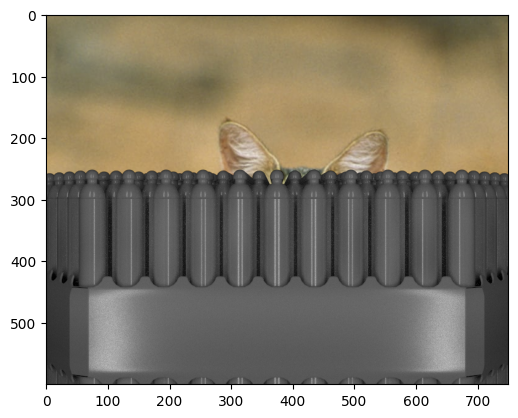

In [48]:
import io
import requests
from PIL import Image
import matplotlib.pyplot as plt  
import scipy.ndimage as ndi

url = 'https://media-cldnry.s-nbcnews.com/image/upload/t_fit-1000w,f_auto,q_auto:best/msnbc/Components/Photos/040408/040408_ancientcat_cat.jpg'
data = requests.get(url).content
background = np.array(Image.open(io.BytesIO(data)))
h,w = base_frame.shape[:2]

foreground = render_tips(has_alpha=True)
plt.imshow(background[:h,:w])
plt.imshow(foreground)

# Gausovský bílý šum

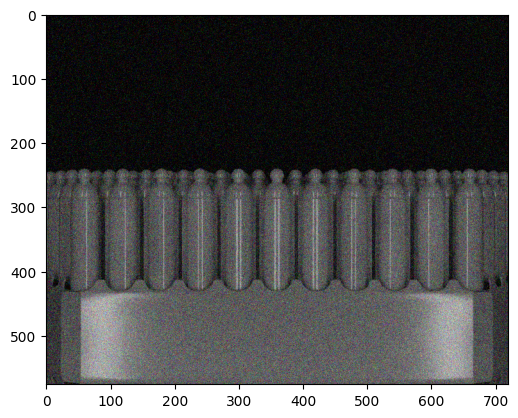

In [68]:
base_frame = render_tips()[12:-12,15:-15]

var = 0.01

gauss = np.random.normal(0, var**0.5, base_frame.shape)
      #gauss = gauss.reshape(row,col,ch)
gauss_frame = base_frame + gauss
gauss_frame[np.where(gauss_frame < 0)] = 0
gauss_frame[np.where(gauss_frame > 1)] = 1

plt.imshow(gauss_frame)


# Blur / Šum

Naimpolementuj na urovni obrazu e.g.

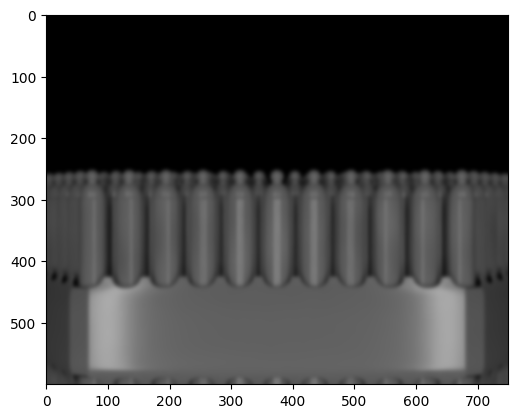

In [49]:
import scipy.ndimage as ndi

plt.imshow(ndi.gaussian_filter(base_frame,3))
plt.show()

# Model špičky a gridu

Model špiček lze změnit. Otevři si `assets/tip_model.ply` v [Blenderu](https://www.blender.org/) a model si předělej. To samé platí pro `assets/grid_wta.ply` (tam najdeš jen jeden zub, který se pak v runtime rozkopíruje).

# True labels

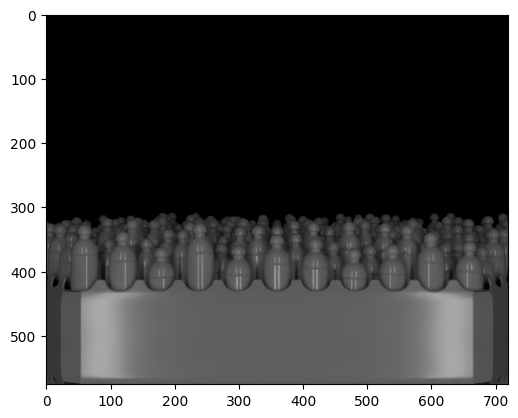

In [217]:
frame, rod_pos = render_tips(z_displacement=10,seed = 123)
frame = frame[12:-12,15:-15]
plt.imshow(frame)
plt.show()

In [170]:
cv2.imwrite("example.png", frame*255)

True

[[ 63.75       -18.517723  ]
 [ 51.         -20.68804607]
 [ 38.25       -26.0138845 ]
 [ 25.5        -18.02551944]
 [ 12.75       -25.26623852]
 [  0.         -21.66929796]
 [-12.75       -22.96508688]
 [-25.5        -26.28710633]
 [-38.25       -25.00394746]
 [-51.         -21.09614434]
 [-63.75       -24.01179585]]
(11, 3)
[[ 40  80 375]
 [100 140 385]
 [160 200 411]
 [220 260 373]
 [280 320 407]
 [340 380 390]
 [400 440 396]
 [460 500 412]
 [520 560 406]
 [580 620 387]
 [640 680 401]]


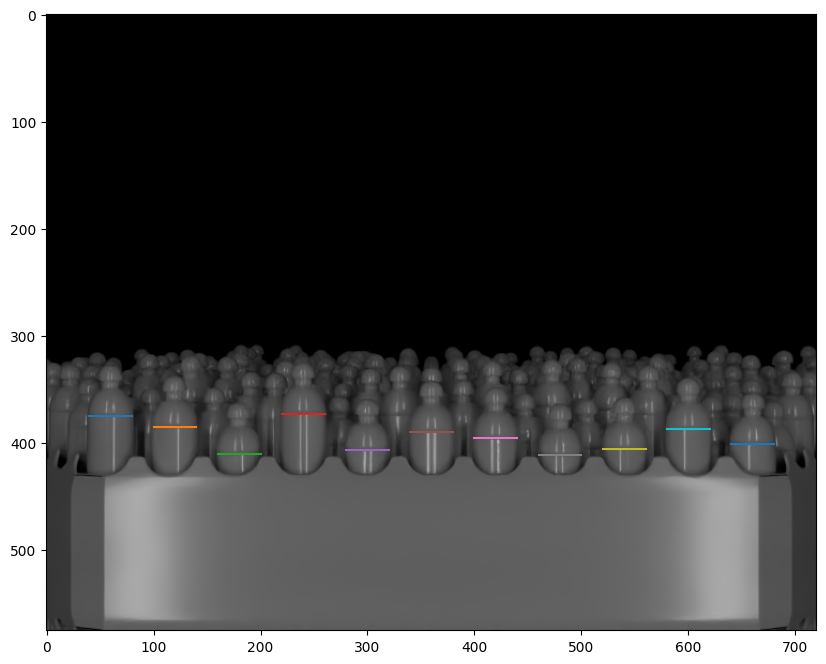

8.261586886409166


In [218]:
print(rod_pos)

rod_pos2 = np.zeros([rod_pos.shape[0],3])
rod_pos2[:,0] = -rod_pos[:,0] * (300 / 63.75) + 360 - 20
rod_pos2[:,1] = -rod_pos[:,0] * (300 / 63.75) + 360 + 20
rod_pos2[:,2] = -rod_pos[:,1] * (276 / 57.83110821) + 287
rod_pos2 = rod_pos2.astype(int)

print(rod_pos2.shape)
print(rod_pos2)

plt.figure(figsize=(10,8))
plt.imshow(frame)
for i in range(len(rod_pos2)):
    p = rod_pos2[i]
    plt.plot([p[0], p[1]], [p[2], p[2]])
plt.show()

frame2 = np.copy(frame)
for i in range(len(rod_pos2)):
    p = rod_pos2[i]
    frame2[p[2],p[0]:p[1],2] = 1

cv2.imwrite("example.png", frame2*255)

print(rod_pos[3,1] - rod_pos[7,1])